In [1]:
from random import random
from matplotlib import pyplot as plt
import numpy as np

def symbol_modulate(QPSK_symbol):
    # Constellation
    # 00 -> A * exp( j * pi / 4)  = 1 + j
    # 01 -> A * exp( j * 3pi / 4) = -1 + j
    # 11 -> A * exp(-j * 3pi / 4) = -1 - j
    # 10 -> A * exp(-j * pi / 4) = 1 - j

    I_sign = 0
    Q_sign = 0

    if QPSK_symbol[0] == 0:
        Q_sign = 1
    else:
        Q_sign = -1

    if QPSK_symbol[1] == 0:
        I_sign = 1
    else:
        I_sign = -1

    return I_sign, Q_sign

def symbol_demodulate(QPSK_signal):
    # See the constellation in modulation.
    I_data = 0
    Q_data = 0

    if QPSK_signal.real > 0:
        Q_data = 0
    else:
        Q_data = 1

    if QPSK_signal.imag > 0:
        I_data = 0
    else:
        I_data = 1

    return I_data, Q_data


In [2]:
# Config
Fs = 8000 # Hz
carrier_frequency = 200
data_size = 10

frequency_step = 1 / Fs
samples = Fs / carrier_frequency * data_size / 2
samples_per_symbol = Fs / carrier_frequency

In [3]:
# Data generation
data = np.arange(data_size)
for n in range(0, data_size):
    if random() > 0.5:
        data[n] = 1
    else:
        data[n] = 0

print(data)

[0 0 0 0 0 0 0 0 0 1]


In [5]:
# Split data into I/Q
I_data = np.arange(data_size / 2)
Q_data = np.arange(data_size / 2)


for n in range(0, data_size, 2):
    I_data[int(n / 2)] = data[n]
for n in range(1, data_size, 2):
    Q_data[int(n / 2)] = data[n]

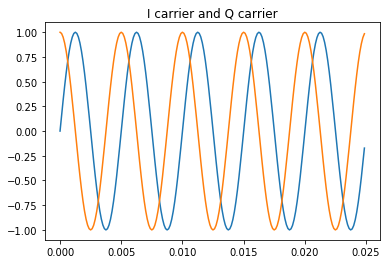

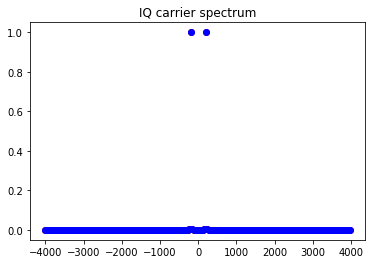

In [6]:
# Generate I/Q carrier
t = np.arange(start = 0, stop = samples * frequency_step, step = frequency_step)
#print t

I_carrier = np.sin(2 * 3.14 * carrier_frequency * t)
Q_carrier = np.cos(2 * 3.14 * carrier_frequency * t)

plt.figure(1)
plt.plot(t, I_carrier, t, Q_carrier)
plt.title('I carrier and Q carrier')
plt.draw()

I_spectrum = np.fft.fft(I_carrier)
Q_spectrum = np.fft.fft(Q_carrier)
freq = np.fft.fftfreq(t.shape[-1], d = frequency_step)

#print freq

plt.figure(2)
plt.plot(freq, np.absolute(I_spectrum) / (samples / 2), 'ro', freq, np.absolute(Q_spectrum) / (samples / 2), 'bo')
plt.title('IQ carrier spectrum')
plt.draw()

I demodulated: [0 0 0 0 0], actual data: [ 0.  0.  0.  0.  0.]
Q demodulated: [0 0 0 0 1], actual data: [ 0.  0.  0.  0.  1.]


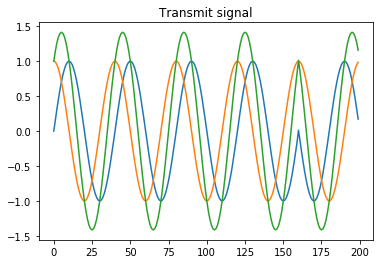

In [11]:
# Modulate carrier with I/Q data
I_modulated = np.arange(samples, dtype=np.float_)
Q_modulated = np.arange(samples, dtype=np.float_)

for n in range(int(data_size / 2)):
    I_sign, Q_sign = symbol_modulate(data[n * 2:n * 2 + 2])
    start = int(n * samples_per_symbol)
    end = int((n + 1) * samples_per_symbol)

    I_modulated[start: end] = I_sign * I_carrier[start: end]
    Q_modulated[start: end] = Q_sign * Q_carrier[start: end]


# Add the I/Q data in time domain
transmit_signal = I_modulated + Q_modulated
plt.figure(3)
plt.plot(np.arange(samples), I_modulated, np.arange(samples), Q_modulated, np.arange(samples), transmit_signal)
plt.title('Transmit signal')
plt.draw()

# Send signal
receive_signal = transmit_signal

# Separate I/Q data and demodulate
I_demodulated = np.arange(len(I_data))
Q_demodulated = np.arange(len(Q_data))

for n in range(len(I_data)):
    start = int(n * samples_per_symbol)
    end = int((n + 1) * samples_per_symbol)

    I_integral = np.sum(receive_signal[start: end] * I_carrier[start: end])
    Q_integral = np.sum(receive_signal[start: end] * Q_carrier[start: end])

    I_demodulated[n], Q_demodulated[n] = symbol_demodulate(np.complex(I_integral, Q_integral))


print(("I demodulated: {}, actual data: {}").format(I_demodulated, I_data))
print(("Q demodulated: {}, actual data: {}").format(Q_demodulated, Q_data))

plt.show()